In [202]:
#import all packages 
import pandas as pd
import warnings
import statsmodels.api as sm
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv('../data/kc_house_data.csv')

In [203]:
# drop columns that have no desire to our stakeholder 
clean_null = data.drop(columns=['id','date','lat','long','yr_built','condition','sqft_living15','sqft_lot15','floors','view', 'waterfront', 'yr_renovated'], axis=1)
clean_null

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,zipcode
0,221900.0,3,1.00,1180,5650,7 Average,1180,0.0,98178
1,538000.0,3,2.25,2570,7242,7 Average,2170,400.0,98125
2,180000.0,2,1.00,770,10000,6 Low Average,770,0.0,98028
3,604000.0,4,3.00,1960,5000,7 Average,1050,910.0,98136
4,510000.0,3,2.00,1680,8080,8 Good,1680,0.0,98074
...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,8 Good,1530,0.0,98103
21593,400000.0,4,2.50,2310,5813,8 Good,2310,0.0,98146
21594,402101.0,2,0.75,1020,1350,7 Average,1020,0.0,98144
21595,400000.0,3,2.50,1600,2388,8 Good,1600,0.0,98027


In [204]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [205]:
clean_null.shape

(21597, 9)

In [206]:
# locating outliers in bedroom 
clean_null = clean_null.loc[clean_null['bedrooms'] < 6]
clean_null = clean_null.loc[clean_null['bathrooms'] < 4]
clean_null = clean_null.loc[clean_null['sqft_living'] < 6000 ]
clean_null = clean_null.loc[clean_null['price'] < 1000000 ]

In [207]:
clean_null.shape

(19741, 9)

In [208]:
clean_null = clean_null.loc[clean_null['bathrooms'] < 4]

In [209]:
clean_null.shape

(19741, 9)

In [210]:
clean_null = clean_null.loc[clean_null['sqft_living'] < 6000 ]

In [211]:
clean_null.shape

(19741, 9)

In [212]:
clean_null = clean_null.loc[clean_null['price'] < 1000000 ]

In [213]:
clean_null.shape

(19741, 9)

In [214]:
clean_null = clean_null.loc[clean_null['sqft_basement'] != '?' ] 

In [215]:
clean_null['sqft_basement'] = clean_null['sqft_basement'].astype(float)

In [216]:
# creating a new feature of price per sqft
clean_null['price_per_sqft'] = clean_null['price']  / clean_null['sqft_above']
clean_null

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,zipcode,price_per_sqft
0,221900.0,3,1.00,1180,5650,7 Average,1180,0.0,98178,188.050847
1,538000.0,3,2.25,2570,7242,7 Average,2170,400.0,98125,247.926267
2,180000.0,2,1.00,770,10000,6 Low Average,770,0.0,98028,233.766234
3,604000.0,4,3.00,1960,5000,7 Average,1050,910.0,98136,575.238095
4,510000.0,3,2.00,1680,8080,8 Good,1680,0.0,98074,303.571429
...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,8 Good,1530,0.0,98103,235.294118
21593,400000.0,4,2.50,2310,5813,8 Good,2310,0.0,98146,173.160173
21594,402101.0,2,0.75,1020,1350,7 Average,1020,0.0,98144,394.216667
21595,400000.0,3,2.50,1600,2388,8 Good,1600,0.0,98027,250.000000


In [217]:
clean_null['true_sqft'] = clean_null['sqft_living']  - clean_null['sqft_basement']
clean_null

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,zipcode,price_per_sqft,true_sqft
0,221900.0,3,1.00,1180,5650,7 Average,1180,0.0,98178,188.050847,1180.0
1,538000.0,3,2.25,2570,7242,7 Average,2170,400.0,98125,247.926267,2170.0
2,180000.0,2,1.00,770,10000,6 Low Average,770,0.0,98028,233.766234,770.0
3,604000.0,4,3.00,1960,5000,7 Average,1050,910.0,98136,575.238095,1050.0
4,510000.0,3,2.00,1680,8080,8 Good,1680,0.0,98074,303.571429,1680.0
...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,8 Good,1530,0.0,98103,235.294118,1530.0
21593,400000.0,4,2.50,2310,5813,8 Good,2310,0.0,98146,173.160173,2310.0
21594,402101.0,2,0.75,1020,1350,7 Average,1020,0.0,98144,394.216667,1020.0
21595,400000.0,3,2.50,1600,2388,8 Good,1600,0.0,98027,250.000000,1600.0


In [218]:
test = [i[0:2].strip() for i in clean_null['grade']]


In [219]:
clean_null['grade_ordinal'] = [int(i[0:2].strip()) for i in clean_null['grade']]

In [220]:
clean_null.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,zipcode,price_per_sqft,true_sqft,grade_ordinal
0,221900.0,3,1.00,1180,5650,7 Average,1180,0.0,98178,188.050847,1180.0,7
1,538000.0,3,2.25,2570,7242,7 Average,2170,400.0,98125,247.926267,2170.0,7
2,180000.0,2,1.00,770,10000,6 Low Average,770,0.0,98028,233.766234,770.0,6
3,604000.0,4,3.00,1960,5000,7 Average,1050,910.0,98136,575.238095,1050.0,7
4,510000.0,3,2.00,1680,8080,8 Good,1680,0.0,98074,303.571429,1680.0,8


In [221]:
zip_home_size = clean_null.loc[clean_null['zipcode'].isin([98052,98102,98103,98105,98109,98119,98121,98134,98164])]

zip_home_size

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,zipcode,price_per_sqft,true_sqft,grade_ordinal
17,485000.0,4,1.00,1600,4300,7 Average,1600,0.0,98103,303.125000,1600.0,7
26,937000.0,3,1.75,2450,2691,8 Good,1750,700.0,98119,535.428571,1750.0,8
29,719000.0,4,2.50,2570,7173,8 Good,2570,0.0,98052,279.766537,2570.0,8
36,550000.0,4,1.00,1660,34848,5 Fair,930,730.0,98052,591.397849,930.0,5
43,685000.0,3,1.00,1570,2280,7 Average,1570,0.0,98119,436.305732,1570.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
21563,645000.0,3,3.25,1730,1229,9 Better,1320,410.0,98119,488.636364,1320.0,9
21567,399950.0,2,1.00,710,1157,7 Average,710,0.0,98102,563.309859,710.0,7
21576,475000.0,3,2.25,1190,1200,8 Good,1190,0.0,98103,399.159664,1190.0,8
21579,520000.0,2,2.25,1530,981,8 Good,1480,50.0,98103,351.351351,1480.0,8


In [222]:
curated_zip = np.array([98052,98102,98103,98105,98109,98119,98121,98134,98164])

In [254]:

# TODO add these OHE'd columns to main data by assigning <dfname>['zipcodes_ohe']
#
# take out the isin function for all zipcodes, if that makes the OLS work. could also narrow down to curated after the OHE on all zipcodes
zips = clean_null.loc[clean_null['zipcode'].isin(curated_zip)].dropna() 
ohe = OneHotEncoder(sparse=False, drop=[98109]) # the zip code with the highest prices in Seattle. could do 98052, near the Microsoft campus as well
ohe.fit(zips['zipcode'].to_numpy().reshape(-1, 1))
zips_encoded = ohe.transform(zips['zipcode'].to_numpy().reshape(-1, 1))

zipcodes_ohe = pd.DataFrame(zips_encoded, columns=ohe.get_feature_names(), index=zips.index)

In [255]:
zipcodes_ohe.shape

(1525, 5)

In [256]:
zipcodes_ohe.head()

,x0_98052,x0_98102,x0_98103,x0_98105,x0_98119
17,0.0,0.0,1.0,0.0,0.0
26,0.0,0.0,0.0,0.0,1.0
29,1.0,0.0,0.0,0.0,0.0
36,1.0,0.0,0.0,0.0,0.0
43,0.0,0.0,0.0,0.0,1.0


In [257]:
zip_home_size.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,zipcode,price_per_sqft,true_sqft,grade_ordinal
17,485000.0,4,1.0,1600,4300,7 Average,1600,0.0,98103,303.125,1600.0,7


In [282]:
zip_new_columns = zip_home_size.drop(columns=['zipcode','grade','sqft_above','sqft_basement',
                                              'sqft_lot',], axis=1)
#zip_new_columns.reset_index(inplace=True, drop=True)
zip_new_columns

,price,bedrooms,bathrooms,sqft_living,price_per_sqft,true_sqft,grade_ordinal
17,485000.0,4,1.00,1600,303.125000,1600.0,7
26,937000.0,3,1.75,2450,535.428571,1750.0,8
29,719000.0,4,2.50,2570,279.766537,2570.0,8
36,550000.0,4,1.00,1660,591.397849,930.0,5
43,685000.0,3,1.00,1570,436.305732,1570.0,7
...,...,...,...,...,...,...,...
21563,645000.0,3,3.25,1730,488.636364,1320.0,9
21567,399950.0,2,1.00,710,563.309859,710.0,7
21576,475000.0,3,2.25,1190,399.159664,1190.0,8
21579,520000.0,2,2.25,1530,351.351351,1480.0,8


In [283]:
# concat two dataframes 
zip_ohe_columns = pd.concat([zip_new_columns , zipcodes_ohe], axis=1)
zip_ohe_columns

,price,bedrooms,bathrooms,sqft_living,price_per_sqft,true_sqft,grade_ordinal,x0_98052,x0_98102,x0_98103,x0_98105,x0_98119
17,485000.0,4,1.00,1600,303.125000,1600.0,7,0.0,0.0,1.0,0.0,0.0
26,937000.0,3,1.75,2450,535.428571,1750.0,8,0.0,0.0,0.0,0.0,1.0
29,719000.0,4,2.50,2570,279.766537,2570.0,8,1.0,0.0,0.0,0.0,0.0
36,550000.0,4,1.00,1660,591.397849,930.0,5,1.0,0.0,0.0,0.0,0.0
43,685000.0,3,1.00,1570,436.305732,1570.0,7,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21563,645000.0,3,3.25,1730,488.636364,1320.0,9,0.0,0.0,0.0,0.0,1.0
21567,399950.0,2,1.00,710,563.309859,710.0,7,0.0,1.0,0.0,0.0,0.0
21576,475000.0,3,2.25,1190,399.159664,1190.0,8,0.0,0.0,1.0,0.0,0.0
21579,520000.0,2,2.25,1530,351.351351,1480.0,8,0.0,0.0,1.0,0.0,0.0


In [284]:
zip_ohe_columns.corr()

,price,bedrooms,bathrooms,sqft_living,price_per_sqft,true_sqft,grade_ordinal,x0_98052,x0_98102,x0_98103,x0_98105,x0_98119
price,1.000000,0.408056,0.324147,0.668496,0.194342,0.584883,0.484944,0.056042,0.073420,-0.249109,0.055191,0.137543
bedrooms,0.408056,1.000000,0.409398,0.644756,-0.301746,0.525441,0.259708,0.348784,-0.072344,-0.242351,-0.004036,-0.070094
bathrooms,0.324147,0.409398,1.000000,0.575086,-0.331088,0.494194,0.560218,0.296183,0.011339,-0.202547,-0.103062,-0.020170
sqft_living,0.668496,0.644756,0.575086,1.000000,-0.381182,0.849593,0.576416,0.482475,-0.067811,-0.331627,-0.074970,-0.067360
price_per_sqft,0.194342,-0.301746,-0.331088,-0.381182,1.000000,-0.620750,-0.328200,-0.513660,0.145666,0.099746,0.184441,0.238904
true_sqft,0.584883,0.525441,0.494194,0.849593,-0.620750,1.000000,0.653428,0.514671,-0.073213,-0.301588,-0.117108,-0.107638
grade_ordinal,0.484944,0.259708,0.560218,0.576416,-0.328200,0.653428,1.000000,0.347539,0.054184,-0.296257,-0.118964,0.020293
x0_98052,0.056042,0.348784,0.296183,0.482475,-0.513660,0.514671,0.347539,1.000000,-0.167147,-0.548158,-0.246370,-0.227450
x0_98102,0.073420,-0.072344,0.011339,-0.067811,0.145666,-0.073213,0.054184,-0.167147,1.000000,-0.172009,-0.077310,-0.071373
x0_98103,-0.249109,-0.242351,-0.202547,-0.331627,0.099746,-0.301588,-0.296257,-0.548158,-0.172009,1.000000,-0.253536,-0.234066


In [287]:

y = zip_ohe_columns['price_per_sqft']
x = zip_ohe_columns['true_sqft']
X_c = sm.add_constant(x)


simple_model = sm.OLS(y, X_c)


simple_model_results = simple_model.fit()
print(simple_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:         price_per_sqft   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     954.8
Date:                Wed, 26 Oct 2022   Prob (F-statistic):          3.70e-163
Time:                        14:06:54   Log-Likelihood:                -9199.6
No. Observations:                1525   AIC:                         1.840e+04
Df Residuals:                    1523   BIC:                         1.841e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        614.2536      6.984     87.952      0.0

In [242]:
#reviewing coef and p value significants 
y = clean_null['price']
X = clean_null.drop(['price','price_per_sqft'], axis=1)





y = y.dropna()
X = X.dropna()

# len(y), len(X)
ols_kch = sm.OLS(y, sm.add_constant(X)).fit()
ols_kch.summary()



ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [290]:
#identifying the lots we recommend the stakeholder purchase and build new multifamily homes. 

zip_lot_size = clean_null.loc[(clean_null['zipcode'].isin([98052,98102,98103,98105,98109,98119,98121,98134,98164]))
                              & (clean_null['sqft_lot'] >= 40000)]

zip_lot_size

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,zipcode,price_per_sqft,true_sqft,grade_ordinal
132,784000.0,3,3.50,3950,111078,9 Better,2460,1490.0,98052,318.699187,2460.0,9
340,485000.0,4,1.75,2560,43995,7 Average,2560,0.0,98052,189.453125,2560.0,7
2580,965000.0,4,2.50,4070,57587,10 Very Good,4070,0.0,98052,237.100737,4070.0,10
2956,900000.0,4,2.50,3620,42580,10 Very Good,3620,0.0,98052,248.618785,3620.0,10
3671,620000.0,3,2.25,2190,45738,8 Good,2190,0.0,98052,283.105023,2190.0,8
6024,822000.0,4,2.50,2683,40386,9 Better,2683,0.0,98052,306.373463,2683.0,9
6578,550000.0,3,2.25,1980,40887,8 Good,1980,0.0,98052,277.777778,1980.0,8
9829,830000.0,4,2.50,1850,50662,8 Good,1430,420.0,98052,580.419580,1430.0,8
11512,849000.0,3,3.00,2960,42159,10 Very Good,2960,0.0,98052,286.824324,2960.0,10
17024,838000.0,4,2.50,3310,42998,9 Better,3310,0.0,98052,253.172205,3310.0,9


In [263]:
#Linearity
X = clean_null.drop(['price'], axis=1).select_dtypes(float,int)
ss = StandardScaler().fit(X)

X_scaled = ss.transform(X)

In [264]:
X_c = sm.add_constant(X_scaled)
y = clean_null['price']

In [265]:
model = sm.OLS(endog=y, exog=X_c).fit()

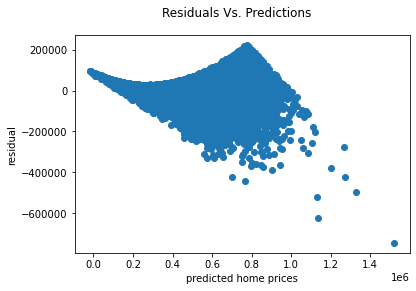

In [266]:
model_preds = model.predict(X_c)
resids = y - model_preds

fig, ax = plt.subplots()

ax.scatter(model_preds, resids)
ax.set_xlabel('predicted home prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');

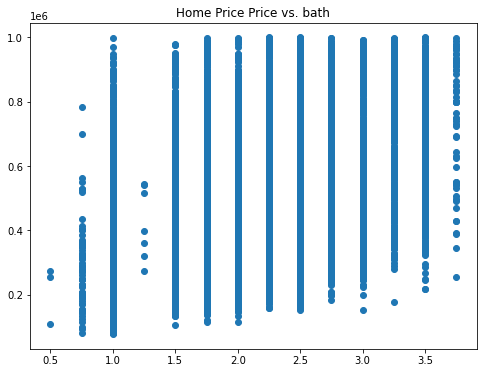

In [267]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 6))


ax.scatter(X['bathrooms'], y)
ax.set_title('Home Price Price vs. bath');

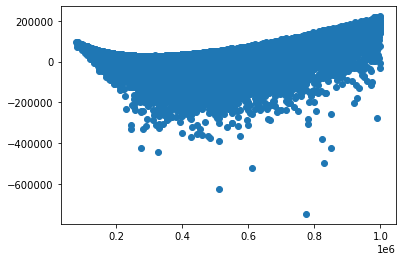

In [268]:
fig, ax = plt.subplots()

ax.scatter(y, resids);

In [269]:
dw = sm.stats.stattools.durbin_watson

In [270]:
dw(resids)

1.9830464294811019

In [271]:
model.summary().tables[2]

Omnibus:,4052.382,Durbin-Watson:,1.983
Prob(Omnibus):,0.000,Jarque-Bera (JB):,18928.456
Skew:,-0.949,Prob(JB):,0.00
Kurtosis:,7.461,Cond. No.,2.63


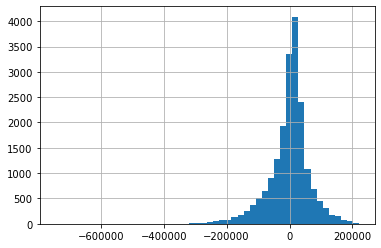

In [272]:
resids.hist(bins=50);

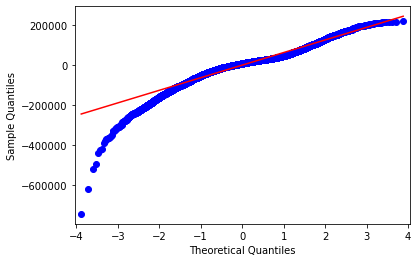

In [273]:
sm.qqplot(resids, line='r');

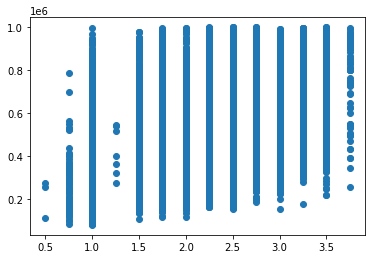

In [274]:
fig, ax = plt.subplots()

ax.scatter(y=clean_null['price'], x=clean_null['bathrooms']);

In [275]:
model.summary().tables[2]

Omnibus:,4052.382,Durbin-Watson:,1.983
Prob(Omnibus):,0.000,Jarque-Bera (JB):,18928.456
Skew:,-0.949,Prob(JB):,0.00
Kurtosis:,7.461,Cond. No.,2.63


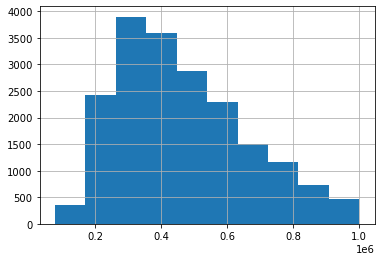

In [276]:
y.hist();

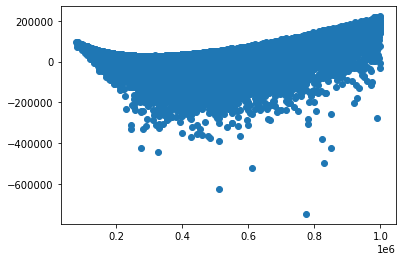

In [277]:
fig, ax = plt.subplots()

ax.scatter(y, resids);

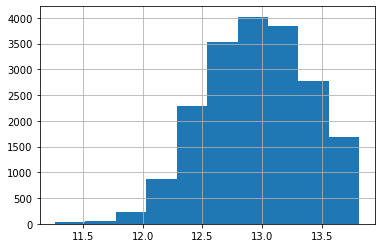

In [278]:
y_log = np.log(y)
y_log.hist();

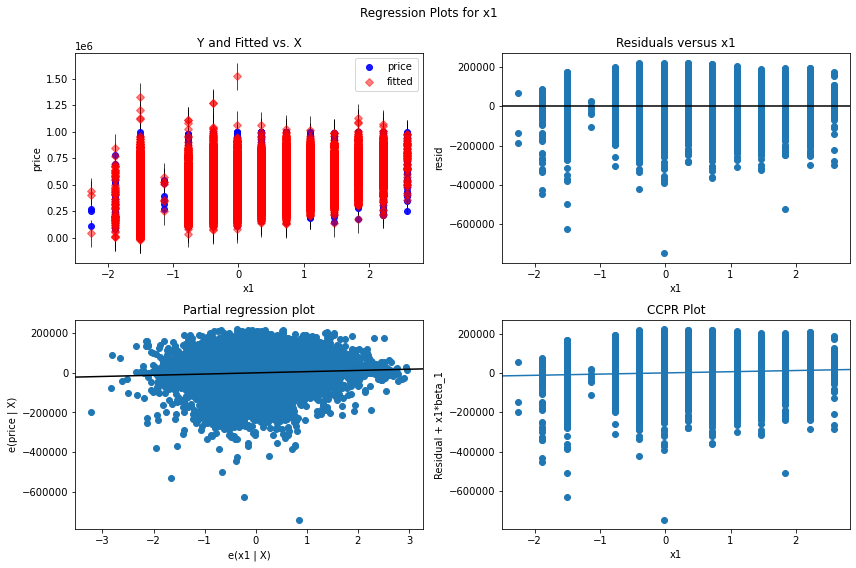

In [279]:
# 'x1' is 
sm.graphics.plot_regress_exog(model, 'x1', fig=plt.figure(figsize=(12, 8)));